In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

In [2]:
#!pip install scikit-learn --user
#!pip install seaborn --user
#!pip install xgboost --user

### 导入数据

In [3]:
power_history_train = pd.read_csv('../raw_data/train/power_forecast_history.csv')

In [4]:
power_history_train['tag']='train'

In [5]:
power_history_test = pd.read_csv('../raw_data/test/power_forecast_history.csv')

In [6]:
power_history_test['tag']='test'

In [7]:
power_history = pd.concat([power_history_train,power_history_test])

In [8]:
power_history.shape

(3650384, 11)

In [9]:
#重构数据，以天为单位
power_history = power_history.groupby(['id_encode','ds','tag'])['ele_price','ser_price','after_ser_price',
                                                       'total_price','f1','f2','f3'].mean().reset_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [10]:
power_history.head()

,id_encode,ds,tag,ele_price,ser_price,after_ser_price,total_price,f1,f2,f3
0,0,20220415,train,0.64,0.95,0.31,0.95,0.0,0.0,1.0
1,0,20220416,train,0.64,0.95,0.31,0.95,0.0,0.0,1.0
2,0,20220417,train,0.64,0.95,0.31,0.95,0.0,0.0,1.0
3,0,20220418,train,0.64,0.95,0.31,0.95,0.0,0.0,1.0
4,0,20220419,train,0.64,0.95,0.31,0.95,0.0,0.0,1.0


In [11]:
power = pd.read_csv('../raw_data/train/power.csv')

In [12]:
power = power.groupby(['id_encode','ds'])['power'].sum().reset_index()

In [13]:
stub_info = pd.read_csv('../raw_data/train/stub_info.csv')

### 可视化EDA

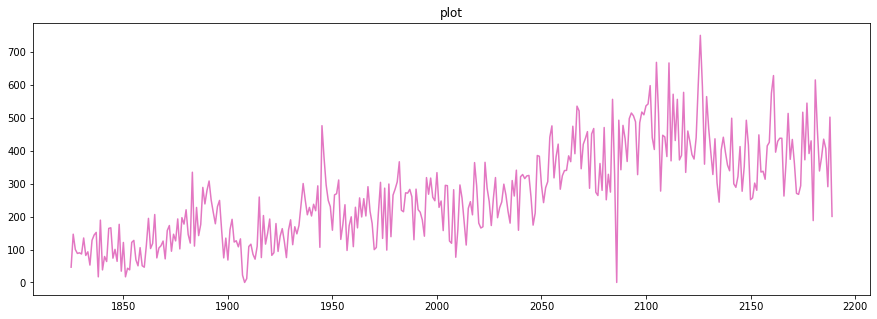

In [45]:
power[power['id_encode']==5]['power'].plot(style='-',
        figsize=(15, 5),
        color=color_pal[6],
        title='plot')
plt.show()

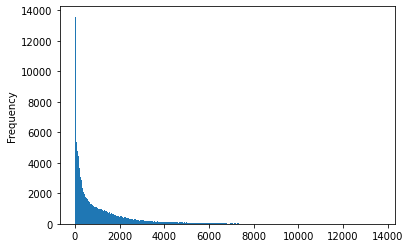

In [15]:
power['power'].plot(kind='hist', bins=500)

In [16]:
power_history.shape

(152544, 10)

#### 合并数据集

In [17]:
power_history = power_history.merge(power,on=['id_encode','ds'],how='left')

In [18]:
power_history = power_history.merge(stub_info,on=['id_encode'],how='left')

In [19]:
#删除训练集power为空的
power_history = power_history[~((power_history['tag']=='train')&(power_history['power'].isnull()))]

### 特征工程

In [20]:
#时间滞后特征
for i in range(7, 14):
    power_history['lag_{}'.format(i)]=power_history.groupby('id_encode')['power'].shift(i)

In [21]:
power_history['date'] = pd.to_datetime(power_history['ds'].astype(str),format='%Y-%m-%d')

In [22]:
power_history = power_history.reset_index(drop=True)

In [23]:
#Create time series features
power_history['dayofweek'] = power_history['date'].dt.dayofweek
power_history['quarter'] = power_history['date'].dt.quarter
power_history['month'] = power_history['date'].dt.month
power_history['dayofyear'] = power_history['date'].dt.dayofyear
power_history['day'] = power_history['date'].dt.day
power_history['weekofyear'] = power_history['date'].dt.weekofyear

In [24]:
df=power_history.copy()

In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['h3'] = le.fit_transform(df['h3'])

In [26]:
df['flag'] = df['flag'].replace({'A':1,'B':2})

In [27]:
df['flag'].value_counts()

1    125067
2     27477
Name: flag, dtype: int64

In [28]:
feat = [i for i in df.columns if i not in['ds','date','power','tag']]

In [29]:
train_x=df[df['tag']=='train'][feat]

In [30]:
train_y=df[df['tag']=='train']['power']

In [31]:
test = df[df['tag']=='test'][feat]

In [32]:
test_p = df[df['tag']=='test'][['id_encode','ds']]

### 建模

In [33]:
folds = 5
seed = 2020
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

#fold = 0
preds = []
oof = np.zeros(train_x.shape[0])
pred = np.zeros(test.shape[0])

scores = []
for train_idx, val_idx in kf.split(train_x, train_y):
    X_train = train_x.iloc[train_idx]
    y_train = train_y.iloc[train_idx]

    X_test = train_x.iloc[val_idx]
    y_test = train_y.iloc[val_idx]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=5000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=7,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    oof[val_idx] =y_pred
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    print('cv_score:',scores)
    
    test_pred = reg.predict(test)
    pred += test_pred / kf.n_splits
    

[0]	validation_0-rmse:1790.24127	validation_1-rmse:1790.87342
[100]	validation_0-rmse:764.83542	validation_1-rmse:776.98547
[200]	validation_0-rmse:454.85014	validation_1-rmse:483.27485
[300]	validation_0-rmse:372.95793	validation_1-rmse:410.91714
[400]	validation_0-rmse:342.96849	validation_1-rmse:385.71770
[500]	validation_0-rmse:326.28358	validation_1-rmse:371.99064
[600]	validation_0-rmse:314.57365	validation_1-rmse:363.06582
[700]	validation_0-rmse:305.09259	validation_1-rmse:356.24017
[800]	validation_0-rmse:298.68514	validation_1-rmse:352.11764
[900]	validation_0-rmse:293.30579	validation_1-rmse:348.63016
[1000]	validation_0-rmse:288.16691	validation_1-rmse:345.30029
[1100]	validation_0-rmse:283.59628	validation_1-rmse:342.59444
[1200]	validation_0-rmse:279.12927	validation_1-rmse:340.26723
[1300]	validation_0-rmse:274.72141	validation_1-rmse:338.33284
[1400]	validation_0-rmse:270.96484	validation_1-rmse:336.66893
[1500]	validation_0-rmse:267.19906	validation_1-rmse:334.74957
[1

In [34]:
pred

array([2126.55264282, 2128.84146118, 2116.40386963, ...,  589.42785645,
        577.35363007,  558.6365509 ])

In [35]:
test_p['power']=pred

In [36]:
test_p[test_p['power']<0]

,id_encode,ds,power
31894,105,20230416,-0.012796
31897,105,20230419,-6.717117
31898,105,20230420,-49.420790
31899,105,20230421,-15.573680
58430,185,20230417,-0.634254
58434,185,20230421,-3.420090


In [37]:
test_p['power']=test_p['power'].apply(lambda x : 0 if x<0 else x)

In [38]:
test_p

,id_encode,ds,power
365,0,20230415,2126.552643
366,0,20230416,2128.841461
367,0,20230417,2116.403870
368,0,20230418,2127.828613
369,0,20230419,2141.299255
...,...,...,...
152539,499,20230417,603.143105
152540,499,20230418,584.137962
152541,499,20230419,589.427856
152542,499,20230420,577.353630


In [39]:
#sub = test_p.groupby(['id_encode','ds'])['power'].sum().reset_index()

In [40]:
sub=test_p.copy()

In [41]:
sub.to_csv('sub.csv',index=False)

### 结果可视化

In [42]:
trian_dd = df[(df['tag']=='train')][['id_encode','ds','power']]
trian_dd = trian_dd.set_index('ds')

In [43]:
test_dd = test_p.copy()
test_dd = test_dd.set_index('ds')

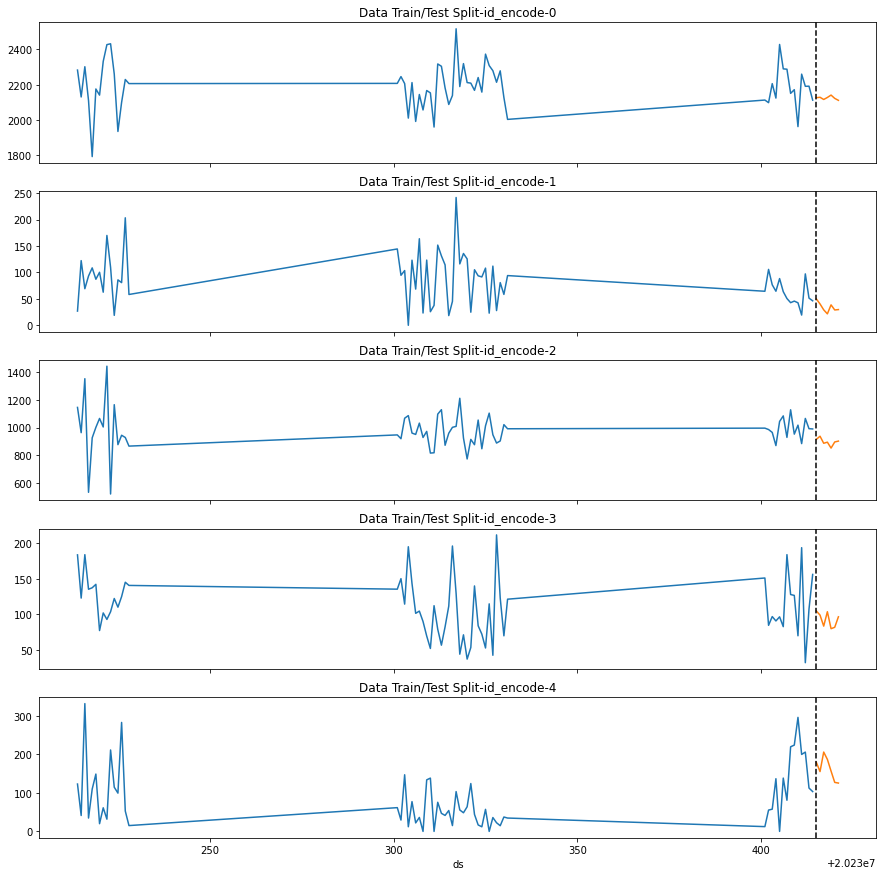

In [44]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
for i in range(5):
    trian_dd[trian_dd['id_encode']==i]['power'][-60:].plot(ax=axs[i],
                      label='Training Set',
                      title='Data Train/Test Split-id_encode-{}'.format(i))
    test_dd[test_dd['id_encode']==i]['power'].plot(ax=axs[i],
                     label='Test Set')
    axs[i].axvline(test_dd.index.min(), color='black', ls='--')